In [1]:
from langgraph.graph import StateGraph, START, END
import operator
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    aggregate: Annotated[list, operator.add]

def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}

builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

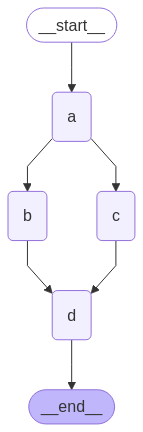

In [2]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "D" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'D']}

In [4]:
def b_2(state: State):
    print(f'Adding "B_2" to {state["aggregate"]}')
    return {"aggregate": ["B_2"]}


builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(b_2)
builder.add_node(c)
builder.add_node(d)
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b_2")
builder.add_edge(["b_2", "c"], "d")  ###
builder.add_edge("d", END)
graph = builder.compile()

In [5]:
graph.invoke({"aggregate": []})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "B_2" to ['A', 'B', 'C']
Adding "D" to ['A', 'B', 'C', 'B_2']


{'aggregate': ['A', 'B', 'C', 'B_2', 'D']}

In [6]:
import operator
from typing import Annotated, Sequence

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add]
    # Add a key to the state. We will set this key to determine
    # how we branch.
    which: str


def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}


def e(state: State):
    print(f'Adding "E" to {state["aggregate"]}')
    return {"aggregate": ["E"]}


builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)
builder.add_node(e)
builder.add_edge(START, "a")


def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


intermediates = ["b", "c", "d"]
builder.add_conditional_edges(
    "a",
    route_bc_or_cd,
    intermediates,
)
for node in intermediates:
    builder.add_edge(node, "e")

builder.add_edge("e", END)
graph = builder.compile()